# Random Walks in n-dimensions
Notebook by Jim Arnold

## Introduction

Problem: given particle that can rest or take a step +/-1 unit in n-dimensions, what's the probability of that particle returning to the origin? How does the probability scale with steps taken? How does it scale with dimensionality?

I think there are multiple ways to approach this, but I'm going to take an analytical approach using NumPy based on an example in 'Python for Data Analysis' by Wes McKinney. 

This is a great exercise and helped me grok ndarrays and the power of NumPy in general. Hope you enjoy!

## Simulating Data

In [1]:
# np is all I need!
import numpy as np

First, define function to take a random walk.

Goal: simulate n particles (let's say 10000), with ability to rest or take a step 1 unit forward or backward in 1D. 

## 1D Random Walk

In [2]:
# using NumPy - define func for generating random walks
def particle_walk_1D(n_walks, n_steps):
    """Given integers for number of steps and number of walks, 
    generates an ndarray of size walks x steps populated with ints 1, 0, -1. 
    Using cumsum on the steps axis provides a tally of particle location at each step
    Returns array of path traveled for each walk
    """

    # first, generate array representing particles' step decision.
    # Options: 0 == rest, 1 == forward, -1 == backward. Do this with randint
    steps = np.random.randint(-1, 2, size=(n_walks, n_steps))

    # tally distance travelled
    walk = steps.cumsum(1)

    # return walk array
    return walk


# using NumPy - define func for evaluating random walks
def origin_return_prob(walk):
    """Given ndarray with axes (n_walks, n_steps), calculates prob of returning to origin.
    Using np.where, evaulate whether a given particle returns to origin (axes == 0)
    Calculate probability that each walk returned to origin.
    Returns probability of particle crossing origin"""

    # apply filter to find walks where particle returned to origin
    ori = np.where((walk == 0).any(axis=1), 1, 0)

    # evaluate P(walks where origin is crossed)
    prob = ori.sum() / len(walk)

    # returns probability that particle will cross origin
    return prob

In [3]:
# test it out
origin_return_prob(particle_walk_1D(n_walks=10000, n_steps=1000))

0.979

Seems to work. See EDA section below for visualizations / me playing around.

Now to generalize it to n-dimensions.

## nD Random Walk

In [4]:
def particle_walk_nD(n_walks, n_steps, n_dims):
    """Given integers for number of steps, number of walks, and number of dimensions
    generates an ndarray of size walks x steps x dims populated with ints 1, 0, -1.
    Using cumsum on the steps axis provides a tally of particle location in each dimension
    Returns array of path traveled for each walk"""

    # first, generate array representing particles' step decision.
    # Options: 0 == rest, 1 == forward, -1 == backward. Do this with randint
    steps = np.random.randint(-1, 2, size=(n_walks, n_steps, n_dims))

    # tally distance travelled
    walk = steps.cumsum(1)
    return walk


# update probability function for ndimensions
def origin_return_prob_nD(walk):
    """Given ndarray with axes (n_walks, n_steps, n_dims), calculates probability particle returned to origin during walk.
    Using np.where, evaulate whether a given particle returns to origin (all axes == 0), then use np.where again to find walks where event occurred.
    Calculate probability that each walk returned to origin.
    Returns probability of particle crossing origin"""

    # apply mask evaluating return to origin on n_dim axis
    d_mask = np.where((walk == 0).all(axis=2), 1, 0)

    # apply filter to find walks where particle returned to origin
    ori = np.where((d_mask == 1).any(axis=1), 1, 0)

    # evaluate P(walks where origin is crossed)
    prob = ori.sum() / len(walk)
    return prob

In [99]:
# test it out
from tqdm import tnrange, tqdm_notebook  # for tracking progress
dims = [1, 2, 3, 4]
for i in tqdm_notebook(dims):
    print('P(%dD walk returns to origin) = %.3f' %
          (i, origin_return_prob_nD(particle_walk_nD(100, 100, i))))

P(1D walk returns to origin) = 0.900
P(2D walk returns to origin) = 0.520
P(3D walk returns to origin) = 0.160
P(4D walk returns to origin) = 0.040


Looks like it works. Appears the probability of returning to origin drops of significantly as dimensionality increases. Makes sense, there's more optionality, and the likelihood should be related to degrees of freedom. Not sure how to test that...

See below for a visual exploration of the simulated data.

## EDA

In [6]:
# here I'm going to capture some simulated data and visualize it to see what can be inferred.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# set plot defaults
sns.set(context='notebook', style='white')

### Visualize 1D Walks

In [100]:
# assume baseline of 1000 independent random walks
n_walks = 1000

# run 1D simulation with increasing number of steps
n_step = [1, 10, 100, 1000, 10000, 100000]
results = {}
for i in tqdm_notebook(n_step):
    results[i] = origin_return_prob(
        particle_walk_1D(n_walks=n_walks, n_steps=i))

In [11]:
# convert results to dataframe
results = pd.DataFrame.from_dict(results, orient='index')
results

,0
1,0.335
10,0.787
100,0.950
1000,0.980
10000,0.995
100000,0.999


Text(0.5, 0, 'steps taken (log scale)')

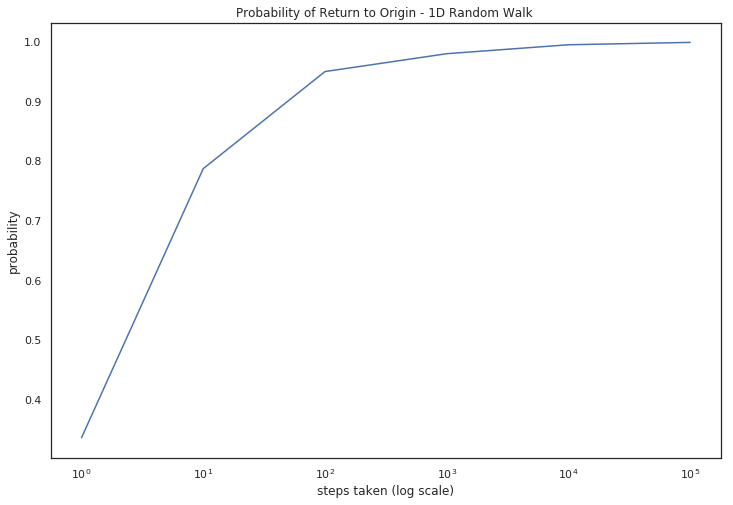

In [16]:
# visualize
plt.figure(figsize=(12, 8))
plt.plot(results)
plt.xscale('log')
plt.title('Probability of Return to Origin - 1D Random Walk ')
plt.ylabel('probability')
plt.xlabel('steps taken (log scale)')

Appears that for 1000 random walks in 1D, the probability of returning to the origin approaches 1.

How does this vary as the number with walks simulated?

In [84]:
# I'm going to start small, too many walks killed my laptop earlier. 
# HEADS UP - running 10000 walks take ~10 minutes on my mine
n_walk = [1, 10, 100, 1000, 1000]

# run 1D simulation with increasing number of steps
n_step = [1, 10, 100, 1000, 10000, 100000]
results = np.empty((len(n_step),len(n_walk)))

# run inefficient for loop
for i in tqdm_notebook(range(len(n_step))):
    for j in tqdm_notebook(range(len(n_walk))):
        results[i,j] = origin_return_prob(
            particle_walk_1D(n_walks=n_walk[j], n_steps=n_step[i]))

100%|██████████| 6/6 [00:03<00:00,  1.03s/it]


Text(0.5, 0, 'steps taken (log scale)')

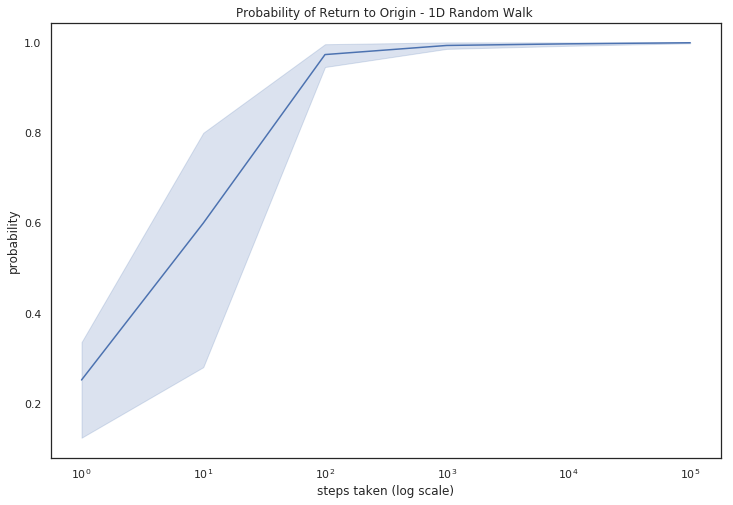

In [85]:
# convert results to dataframe, pivot to long form
results = pd.DataFrame(results, index=n_step, columns=n_walk)
# add steps as col
results["steps"] = results.index
# melt
results = results.melt(id_vars="steps", var_name="particles")

# visualize with seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(x="steps", y="value", data=results)
plt.xscale('log')
plt.title('Probability of Return to Origin - 1D Random Walk ')
plt.ylabel('probability')
plt.xlabel('steps taken (log scale)')

Look at that uncertainty disappearing.

Text(0.5, 0, 'steps taken (log scale)')

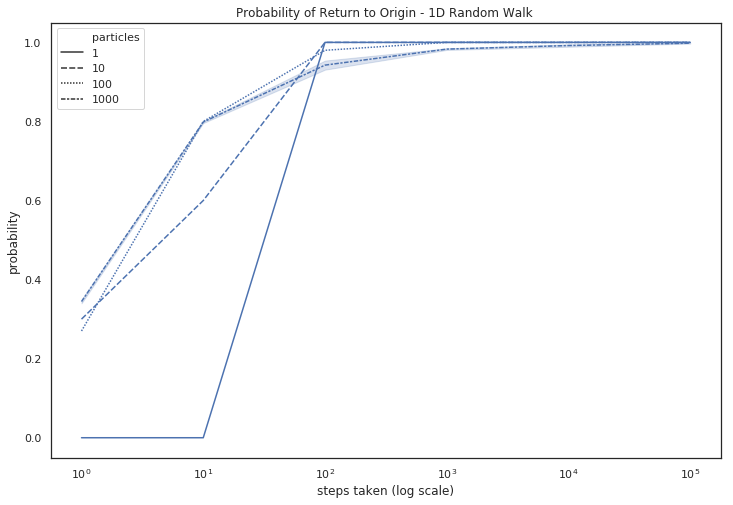

In [90]:
# visualize with seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(x="steps", y="value", style="particles", data=results)
plt.xscale('log')
plt.title('Probability of Return to Origin - 1D Random Walk ')
plt.ylabel('probability')
plt.xlabel('steps taken (log scale)')

Not that surprising, given each particle has a 33% chance of initializing at 0. As the number of particles increases, the expected probability becomes realized. 

Given that 10000 particles kills my laptop, I'm going to keep moving forward with 1000 particle simulations.

Check how consistent this over 10 runs.

Text(0.5, 0, 'steps taken (log scale)')

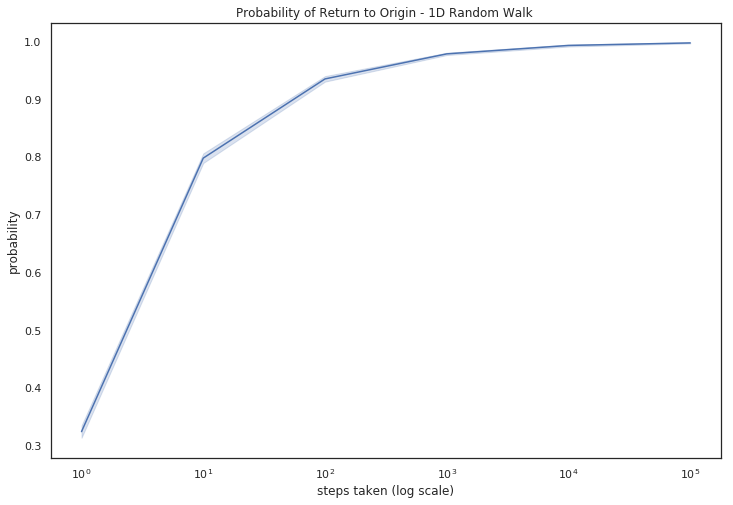

In [105]:
# simulate n runs
n = 10

# run 1D simulation with increasing number of steps
n_step = [1, 10, 100, 1000, 10000, 100000]
results = np.empty((len(n_step), len(range(n))))

# run inefficient for loop
for i in tqdm_notebook(range(n)):
    for j in range(len(n_step)):
        results[j, i] = origin_return_prob(
            particle_walk_1D(n_walks=1000, n_steps=n_step[j]))
        
        
# convert results to dataframe, pivot to long form
results = pd.DataFrame(results, index=n_step)
# add steps as col
results["steps"] = results.index
# melt
results = results.melt(id_vars="steps")

# visualize with seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(x="steps", y="value", data=results)
plt.xscale('log')
plt.title('Probability of Return to Origin - 1D Random Walk ')
plt.ylabel('probability')
plt.xlabel('steps taken (log scale)')

Super consistent.

I want to inspect the distance traveled as well. Visualize the walk path.

Text(0.5, 0, 'steps taken')

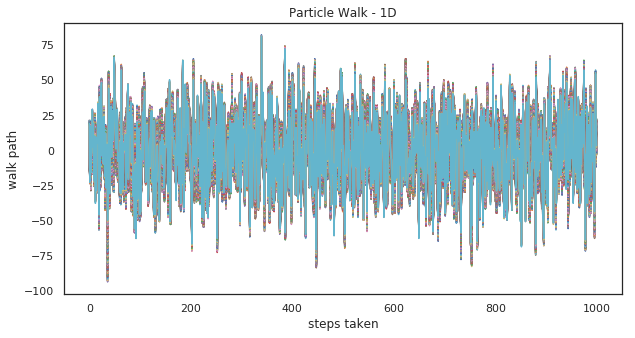

In [106]:
w = particle_walk_1D(n_walks=1000, n_steps=1000)

# visualize walk
plt.figure(figsize=(10, 5))
plt.plot(w)
plt.title('Particle Walk - 1D')
plt.ylabel('walk path')
plt.xlabel('steps taken')

In [107]:
# find max distance traveled in either direction
print('Farthest Forward:',w.max())
print('Farthest Back:',w.min())

Farthest Forward: 82
Farthest Back: -94


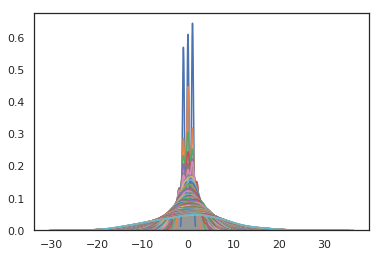

In [151]:
# generate density plot for location reached in first 100 steps
for col in np.arange(100):
    sns.kdeplot(w[:,col], shade=True)

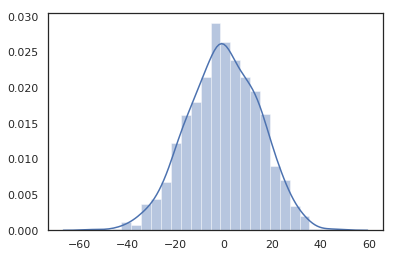

In [152]:
# hist of mean distance traveled for each particle
sns.distplot(w.mean(axis=1))

Things to think about - there's probably an equation or stats approach to describe this. 

What's the expected distance traveled given a 33% chance of moving forward, a 33% chance or moving backward, and a 33% chance of not moving?

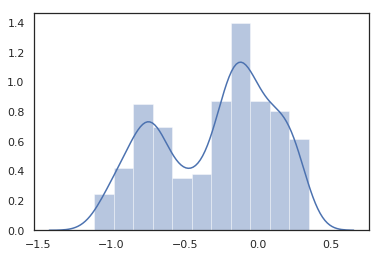

In [153]:
# hist of mean step distance
sns.distplot(w.mean(axis=0))

This is unexpected, looks like a decent number of particles trend negative. 

Expected even spread around 0. Maybe there's a flaw in my code, or maybe randint is slightly biased?

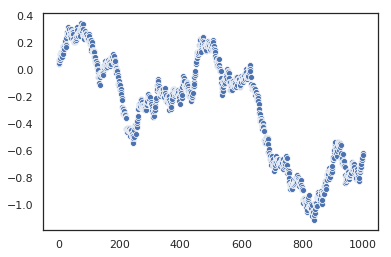

In [174]:
# scattplot of mean distance traveled per step
sns.scatterplot(x=range(len(w)),y=w.mean(axis=0))

Big drop around 600, maybe it's just this run.

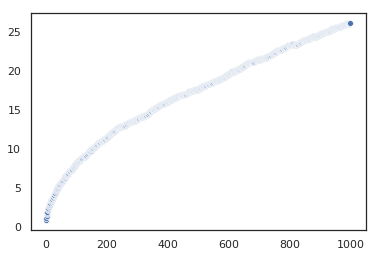

In [165]:
# scattplot of std at each step
sns.scatterplot(x=range(len(w)),y=w.std(axis=0))

### Visualize nD walks

In [212]:
# time to visualize how probability changes with respect to degrees of freedom.
# test 5 dimensions, with 1000 particles each run, and also vary the number of steps
dims = [1, 2, 3, 4, 5]
n_step = [10, 100, 1000, 10000, 100000]
results = np.empty((len(dims), len(n_step)))

# run inefficient for loop
for i in tqdm_notebook(range(len(dims))):
    for j in tqdm_notebook(range(len(n_step))):
        results[i, j] = origin_return_prob_nD(particle_walk_nD(
            n_walks=1000, n_steps=n_step[j], n_dims=dims[i]))

In [213]:
# convert results to dataframe, pivot to long form
result = pd.DataFrame(results, index=dims, columns=n_step)
# add steps as col
result["dimensions"] = result.index
# melt
result = result.melt(id_vars="dimensions", var_name="steps")
result

,dimensions,steps,value
0,1,10,0.775
1,2,10,0.380
2,3,10,0.142
3,4,10,0.055
4,5,10,0.013
5,1,100,0.919
6,2,100,0.524
7,3,100,0.150
8,4,100,0.037
9,5,100,0.007


Text(0.5, 0, 'steps taken (log scale)')

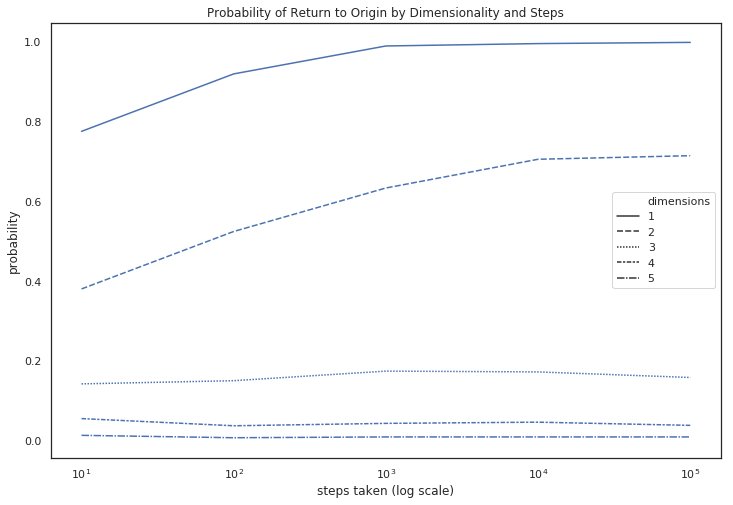

In [214]:
# visualize with seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(x="steps", y="value", style="dimensions", data=result)
plt.xscale('log')
plt.title('Probability of Return to Origin by Dimensionality and Steps')
plt.ylabel('probability')
plt.xlabel('steps taken (log scale)')

Text(0.5, 0, 'dimensions')

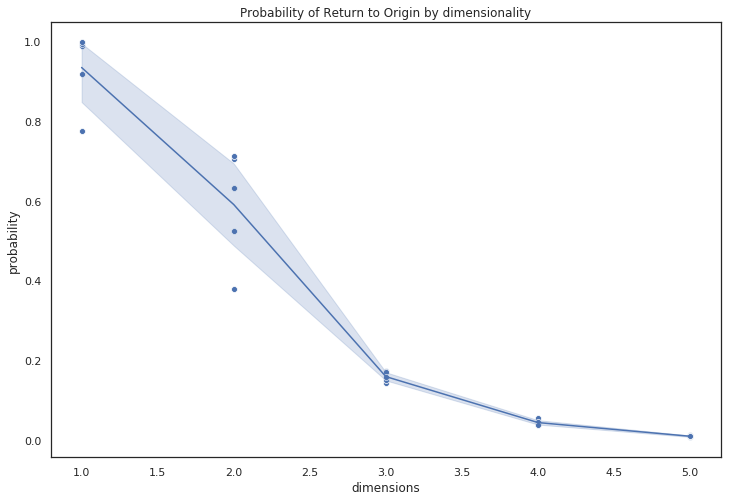

In [236]:
# visualize the probability as a function of dimensions
plt.figure(figsize=(12, 8))
sns.scatterplot(x="dimensions", y="value", data=result)
sns.lineplot(x="dimensions", y="value", data=result)
plt.title('Probability of Return to Origin by dimensionality')
plt.ylabel('probability')
plt.xlabel('dimensions')

There's clearly a relationship between dimension (degrees of freedom) and the probability of returning to the origin.

In [217]:
# inspect the prob on the largest sim 
result[result.steps == 100000]

,dimensions,steps,value
20,1,100000,0.998
21,2,100000,0.714
22,3,100000,0.158
23,4,100000,0.038
24,5,100000,0.009


After a quick google, I think this looks like it might be geometrically or exponetially distributed.

In [262]:
for i in dims:
    print((0.33**i)*(1-0.33))

0.2211
0.072963
0.024077789999999998
0.0079456707
0.0026220713310000005
